<a href="https://colab.research.google.com/github/gjduart/Machine-Learning/blob/main/Kernel_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aluno: Gabriel Jonas da Silva Duarte


In [ ]:
!wget --no-check-certificate \
    "https://www.dropbox.com/s/s2cyx82uxsv03rq/dados-ex5.txt?dl=0" \
    -O "/tmp/dados-ex5.txt"


--2020-10-27 02:39:40--  https://www.dropbox.com/s/s2cyx82uxsv03rq/dados-ex5.txt?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/s2cyx82uxsv03rq/dados-ex5.txt [following]
--2020-10-27 02:39:41--  https://www.dropbox.com/s/raw/s2cyx82uxsv03rq/dados-ex5.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc555e7bd7a4f7c7ff9b6ab3e5a5.dl.dropboxusercontent.com/cd/0/inline/BCChmw2jP2D09mZC6pDODwGkP3_YlzhxpuxMw__U-9gwBw-k3jQZ_ttVSkjS2BlB5xLz2UKBBtuIj_2vcYh70hQmnezd47vKr0SchEVGWR4n2dyZcUhlr-UihgaKK_lgESU/file# [following]
--2020-10-27 02:39:41--  https://uc555e7bd7a4f7c7ff9b6ab3e5a5.dl.dropboxusercontent.com/cd/0/inline/BCChmw2jP2D09mZC6pDODwGkP3_YlzhxpuxMw__U-9gwBw-k3jQZ_ttVSkjS2BlB5xLz2UKBBtuIj_2vcYh70hQmnezd47vKr0SchEVGWR

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

In [ ]:
dset = np.genfromtxt('/tmp/dados-ex5.txt',delimiter=',') #Importa os dados

x = dset[:,:-1]
y = dset[:,-1]
y[y>0] = 1
y[y<=0] = -1
from sklearn.model_selection import train_test_split
#Separando 80% para treino e 20% para teste
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=100)

'''
Y_train[Y_train > 0] = 1
Y_train[Y_train <= 0] = -1

Y_test[Y_test > 0] = 1
Y_test[Y_test <= 0] = -1'''

'\nY_train[Y_train > 0] = 1\nY_train[Y_train <= 0] = -1\n\nY_test[Y_test > 0] = 1\nY_test[Y_test <= 0] = -1'

In [ ]:
import numpy as np
from numpy import linalg as aLinear
import cvxopt
import cvxopt.solvers
             
def linear(x1, x2):
    return np.dot(x1, x2)

def RBF(x, y, sigma=5.0):
    return np.exp(-aLinear.norm(x-y)**2 / (2 * (sigma ** 2)))

class SVM(object):

    def __init__(self, kernel=linear, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None:
           self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gerando Matrix de Gram
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        #Convertendo e computando para cvxopt para o nosso solver
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # resolvendo o nosso problema de programação quadrática
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Multiplicadores de Lagrange
        a = np.ravel(solution['x'])

        # Os vetores de suporte têm multiplicadores de lagrange diferentes de zero
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # vetor W
        if self.kernel == linear:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def projetar(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.projetar(X))


Definindo um método para realizar o plot do SVM com kernel RBF

In [ ]:
def plot_contorno(X1_train, X2_train, clf):
    plt.plot(X1_train[:,0], X1_train[:,1], "ro")
    plt.plot(X2_train[:,0], X2_train[:,1], "bo")
    plt.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="goldenrod")
        
    X1, X2 = np.meshgrid(np.linspace(-1,1,50), np.linspace(-1,1,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = clf.projetar(X).reshape(X1.shape)
    plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
       
    
    plt.show()

Definindo um método para plotagem do SVM com kernel linear

In [ ]:
def plot_margem(X1_train, X2_train, clf):
        
    def f(x, w, b, c=0):
            # w.x + b = c
        return (-w[0] * x - b + c) / w[1]
        
    plt.plot(X1_train[:,0], X1_train[:,1], "ro")
    plt.plot(X2_train[:,0], X2_train[:,1], "bo")
    plt.scatter(clf.sv[:,0], clf.sv[:,1],  c="goldenrod")
        
        # w.x + b = 0
    a0 = -1
    a1 = f(a0, clf.w, clf.b)
    b0 = 1
    b1 = f(b0, clf.w, clf.b)
    plt.plot([a0,b0], [a1,b1], "k")
        
        # w.x + b = 1
    a0 = -1
    a1 = f(a0, clf.w, clf.b, 1)
    b0 = 1
    b1 = f(b0, clf.w, clf.b, 1)
    plt.plot([a0,b0], [a1,b1], "k--")
        
        # w.x + b = -1
    a0 = -1
    a1 = f(a0, clf.w, clf.b, -1)
    b0 = 1
    b1 = f(b0, clf.w, clf.b, -1)
    plt.plot([a0,b0], [a1,b1], "k--")
        
    
    plt.show()

In [ ]:
import matplotlib.pyplot as pl
def SVM_RBF(X_train,Y_train,C=None):

  clf = SVM(C=C,kernel=RBF)
  clf.fit(X_train, Y_train)
        
  y_predict = clf.predict(X_test)
  correto = np.sum(y_predict == Y_test)
  print(f'{correto} de {len(y_predict)} são predições corretas')
          
  plot_contorno(X_train[Y_train==1], X_train[Y_train==-1], clf)

Linear

     pcost       dcost       gap    pres   dres
 0: -1.5376e+02 -1.6151e+02  6e+03  3e+01  6e-15
 1: -2.3927e+01 -1.5160e+02  3e+02  7e-01  6e-15
 2: -1.9058e+01 -5.1366e+01  3e+01  5e-16  1e-15
 3: -2.2765e+01 -2.9127e+01  6e+00  8e-16  1e-15
 4: -2.4253e+01 -2.6500e+01  2e+00  4e-16  9e-16
 5: -2.4831e+01 -2.5585e+01  8e-01  6e-16  9e-16
 6: -2.4970e+01 -2.5370e+01  4e-01  3e-16  8e-16
 7: -2.5072e+01 -2.5215e+01  1e-01  3e-16  8e-16
 8: -2.5115e+01 -2.5155e+01  4e-02  2e-16  9e-16
 9: -2.5128e+01 -2.5138e+01  1e-02  8e-16  9e-16
10: -2.5133e+01 -2.5133e+01  4e-04  1e-15  1e-15
11: -2.5133e+01 -2.5133e+01  7e-06  1e-15  1e-15
Optimal solution found.
159 de 180 são predições corretas


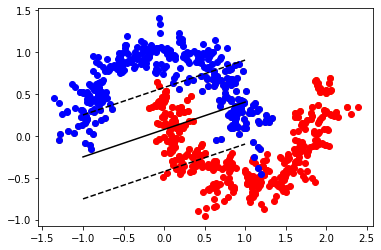

In [ ]:

clf = SVM(C=0.1)
clf.fit(X_train, Y_train)
        
y_predict = clf.predict(X_test)
correto = np.sum(y_predict == Y_test)
print(f'{correto} de {len(y_predict)} são predições corretas')
        
plot_margem(X_train[Y_train==1], X_train[Y_train==-1], clf)

     pcost       dcost       gap    pres   dres
 0: -1.4596e+03 -4.3675e+04  9e+04  6e-01  6e-14
 1: -1.3137e+03 -9.3464e+03  8e+03  2e-03  5e-14
 2: -1.6662e+03 -3.0871e+03  1e+03  3e-04  5e-14
 3: -1.9199e+03 -2.7601e+03  8e+02  1e-04  6e-14
 4: -2.0153e+03 -2.5873e+03  6e+02  7e-05  5e-14
 5: -2.1012e+03 -2.4432e+03  3e+02  4e-05  6e-14
 6: -2.1478e+03 -2.3662e+03  2e+02  2e-05  6e-14
 7: -2.1801e+03 -2.3156e+03  1e+02  1e-05  6e-14
 8: -2.2048e+03 -2.2778e+03  7e+01  6e-06  7e-14
 9: -2.2160e+03 -2.2601e+03  4e+01  3e-06  7e-14
10: -2.2244e+03 -2.2481e+03  2e+01  1e-06  7e-14
11: -2.2319e+03 -2.2376e+03  6e+00  8e-08  8e-14
12: -2.2325e+03 -2.2367e+03  4e+00  4e-08  7e-14
13: -2.2343e+03 -2.2348e+03  6e-01  1e-13  8e-14
14: -2.2345e+03 -2.2345e+03  9e-03  1e-13  8e-14
15: -2.2345e+03 -2.2345e+03  9e-05  7e-14  7e-14
Optimal solution found.
158 de 180 são predições corretas


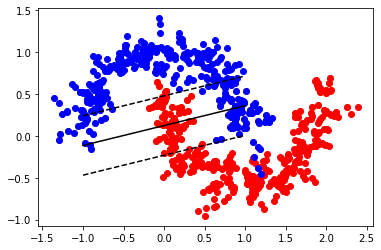

In [ ]:
clf = SVM(C=10)
clf.fit(X_train, Y_train)
        
y_predict = clf.predict(X_test)
correto = np.sum(y_predict == Y_test)
print(f'{correto} de {len(y_predict)} são predições corretas')
        
plot_margem(X_train[Y_train==1], X_train[Y_train==-1], clf)

     pcost       dcost       gap    pres   dres
 0: -8.1763e+02 -1.3550e+04  3e+04  7e-01  3e-14
 1: -7.3876e+02 -3.9657e+03  4e+03  2e-02  3e-14
 2: -8.8398e+02 -1.5304e+03  7e+02  4e-03  3e-14
 3: -9.9247e+02 -1.3426e+03  4e+02  2e-03  3e-14
 4: -1.0462e+03 -1.2403e+03  2e+02  7e-04  3e-14
 5: -1.0803e+03 -1.1814e+03  1e+02  3e-04  3e-14
 6: -1.0992e+03 -1.1508e+03  5e+01  2e-04  3e-14
 7: -1.1058e+03 -1.1401e+03  3e+01  9e-05  3e-14
 8: -1.1130e+03 -1.1279e+03  1e+01  3e-05  4e-14
 9: -1.1159e+03 -1.1236e+03  8e+00  8e-06  4e-14
10: -1.1175e+03 -1.1214e+03  4e+00  3e-06  4e-14
11: -1.1180e+03 -1.1208e+03  3e+00  9e-07  3e-14
12: -1.1192e+03 -1.1195e+03  3e-01  6e-08  4e-14
13: -1.1193e+03 -1.1193e+03  4e-02  6e-09  4e-14
14: -1.1193e+03 -1.1193e+03  8e-04  1e-10  4e-14
Optimal solution found.
158 de 180 são predições corretas


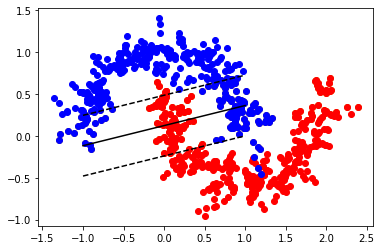

In [ ]:
clf = SVM(C=5)
clf.fit(X_train, Y_train)
        
y_predict = clf.predict(X_test)
correto = np.sum(y_predict == Y_test)
print(f'{correto} de {len(y_predict)} são predições corretas')
        
plot_margem(X_train[Y_train==1], X_train[Y_train==-1], clf)

RBF 

     pcost       dcost       gap    pres   dres
 0: -3.5386e+02 -3.7480e+04  6e+04  3e-01  5e-14
 1: -7.1392e+02 -6.3314e+03  6e+03  5e-03  5e-14
 2: -1.5965e+03 -3.7030e+03  2e+03  2e-03  5e-14
 3: -1.8764e+03 -3.0924e+03  1e+03  8e-04  6e-14
 4: -2.0489e+03 -2.7322e+03  7e+02  4e-04  6e-14
 5: -2.1334e+03 -2.5952e+03  5e+02  3e-04  6e-14
 6: -2.1876e+03 -2.5047e+03  3e+02  2e-04  6e-14
 7: -2.2168e+03 -2.4581e+03  2e+02  1e-04  7e-14
 8: -2.2457e+03 -2.4129e+03  2e+02  7e-05  6e-14
 9: -2.2637e+03 -2.3855e+03  1e+02  4e-05  7e-14
10: -2.2866e+03 -2.3506e+03  6e+01  2e-05  7e-14
11: -2.3032e+03 -2.3268e+03  2e+01  7e-07  8e-14
12: -2.3094e+03 -2.3196e+03  1e+01  2e-07  8e-14
13: -2.3134e+03 -2.3150e+03  2e+00  2e-16  9e-14
14: -2.3142e+03 -2.3143e+03  1e-01  6e-14  9e-14
15: -2.3142e+03 -2.3142e+03  4e-03  6e-14  9e-14
16: -2.3142e+03 -2.3142e+03  4e-05  9e-14  9e-14
Optimal solution found.
158 de 180 são predições corretas


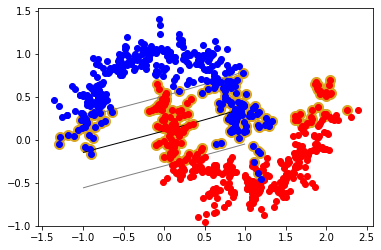

In [ ]:
 A = SVM_RBF(X_train,Y_train, C=10)
 A

     pcost       dcost       gap    pres   dres
 0: -5.6928e+02 -1.1896e+04  2e+04  5e-01  4e-14
 1: -5.7842e+02 -2.7531e+03  2e+03  2e-14  3e-14
 2: -9.2720e+02 -1.6442e+03  7e+02  1e-14  3e-14
 3: -1.0451e+03 -1.4344e+03  4e+02  4e-14  3e-14
 4: -1.1051e+03 -1.3340e+03  2e+02  3e-14  3e-14
 5: -1.1398e+03 -1.2779e+03  1e+02  1e-14  4e-14
 6: -1.1608e+03 -1.2473e+03  9e+01  1e-14  4e-14
 7: -1.1766e+03 -1.2257e+03  5e+01  2e-14  4e-14
 8: -1.1847e+03 -1.2141e+03  3e+01  4e-14  4e-14
 9: -1.1916e+03 -1.2046e+03  1e+01  2e-15  4e-14
10: -1.1947e+03 -1.2007e+03  6e+00  3e-14  4e-14
11: -1.1968e+03 -1.1980e+03  1e+00  1e-14  4e-14
12: -1.1973e+03 -1.1975e+03  2e-01  2e-14  4e-14
13: -1.1973e+03 -1.1974e+03  4e-02  3e-14  4e-14
14: -1.1973e+03 -1.1974e+03  4e-03  3e-14  4e-14
15: -1.1973e+03 -1.1973e+03  1e-04  9e-15  5e-14
Optimal solution found.
159 de 180 são predições corretas


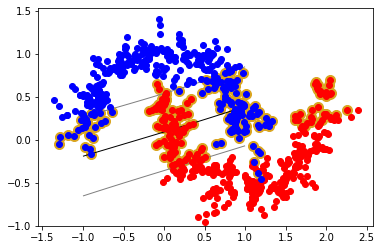

In [ ]:
B = SVM_RBF(X_train,Y_train, C=5)
B

     pcost       dcost       gap    pres   dres
 0: -2.9713e+02 -9.3771e+02  3e+03  4e+01  3e+00
 1: -8.0837e+02 -1.9614e+03  3e+03  3e+01  2e+00
 2: -1.1331e+03 -2.5863e+03  3e+03  3e+01  2e+00
 3: -3.5588e+03 -5.3990e+03  2e+03  2e+01  1e+00
 4: -1.2406e+04 -1.4338e+04  2e+03  1e+01  1e+00
 5: -4.0045e+04 -4.4972e+04  5e+03  1e+01  1e+00
 6: -1.5355e+05 -1.6600e+05  1e+04  1e+01  1e+00
 7: -3.6291e+05 -3.7873e+05  2e+04  1e+01  1e+00
 8: -7.9640e+05 -8.2359e+05  3e+04  1e+01  1e+00
 9: -1.3695e+06 -1.4122e+06  4e+04  1e+01  1e+00
10: -3.0075e+06 -3.0958e+06  9e+04  1e+01  1e+00
11: -3.1253e+06 -3.2167e+06  9e+04  1e+01  1e+00
12: -8.6057e+06 -8.8397e+06  2e+05  1e+01  1e+00
13: -2.4484e+07 -2.5111e+07  6e+05  1e+01  1e+00
14: -2.6874e+07 -2.7558e+07  7e+05  1e+01  1e+00
15: -8.7525e+07 -8.9608e+07  2e+06  1e+01  1e+00
16: -1.1086e+08 -1.1347e+08  3e+06  1e+01  1e+00
17: -6.0334e+08 -6.1622e+08  1e+07  1e+01  1e+00
18: -8.4363e+08 -8.6153e+08  2e+07  1e+01  1e+00
19: -3.3975e+09 -3.46

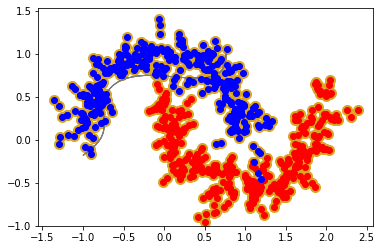

In [ ]:
C = SVM_RBF(X_train,Y_train, C=None)
C